In [1]:
import numpy as np
from scipy import interpolate, integrate

import os, sys

import logging 

import matplotlib.pyplot as plt

from copy import copy

import h5py

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [4]:
from test_algorithms import test_data, calibration_data

In [5]:
from imucapture.ic_process import Ic_process, eul2rotm, rotm2eul
from imucapture.ic_data import Ic_data
from imucapture.ic_get_basis import Ic_get_basis

In [6]:
timescale = 1000.0

# Initial setup

The chip is initially on its side, like it would be on a fish, but not perfectly aligned

In [7]:
initial_chip_orient = np.deg2rad((5, 5, 0))
chip2world = eul2rotm(initial_chip_orient)

The rotation matrix has the chip's axes in columns, expressed in world coordinates.  So the chip's x axis is mostly aligned along the world's x, but the chip's y axis is mostly along the world's negative z.

In [8]:
print(chip2world)

[[ 0.9961947   0.         -0.08715574]
 [ 0.00759612  0.9961947   0.08682409]
 [ 0.08682409 -0.08715574  0.99240388]]


Generate calibration data

In [9]:
calib = calibration_data(30, chip2world)
calib.add_noise(0.1, 10.0, 0.02, 15.0, 0.0, 0.2)

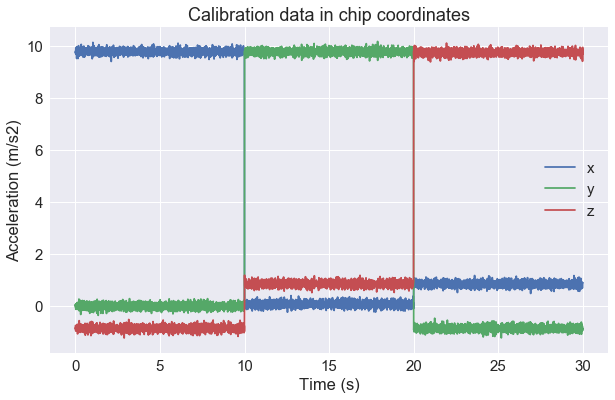

In [10]:
plt.plot(calib.t, calib.acc)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s2)')
plt.title('Calibration data in chip coordinates')
plt.legend(['x','y','z'])
plt.show()

The calibration procedure is as follows.  Align the fish, with the chip attached, so that gravity points along the what we want to be the x axis, then along the y axis, then along z.

Now run the calibration algorithm based on the data above.

In [11]:
get_basis = Ic_get_basis()
intervals = get_basis.get_intervals(calib)

INFO:root:found 3 steady intervals:


INFO:root:[(0, 2001), (2001, 4001), (4001, 6000)]


In [12]:
basis_vector = get_basis.get_basis_vector(calib, intervals)

INFO:root:found approximately orthogonal vectors:
(9.767890384364879, 0.0049568733623101269, -0.85420782307501408)
(0.074814331328034611, 9.7673260197985279, 0.85626811878078002)
(0.85177684932557984, -0.85507406172739009, 9.7355259070471991)


INFO:root:applying Gram-Schmidt


Show the basis matrix.  The columns are the chip's axes, expressed in world coordinates.

In [13]:
world_basis = np.array(basis_vector)
print(world_basis)

[[  9.96190478e-01  -2.10627105e-05  -8.72039628e-02]
 [  7.63003285e-03   9.96185860e-01   8.69224683e-02]
 [  8.68695238e-02  -8.72567044e-02   9.92391028e-01]]


The world_basis matrix should be the same as the original chip2world matrix.  Check.

In [14]:
print("world_basis = \n{}".format(np.round(world_basis, decimals=3)))
print("chip2world = \n{}".format(np.round(chip2world, decimals=3)))
print("norm of difference = {}".format(np.linalg.norm(world_basis - chip2world)))

world_basis = 
[[ 0.996 -0.    -0.087]
 [ 0.008  0.996  0.087]
 [ 0.087 -0.087  0.992]]
chip2world = 
[[ 0.996  0.    -0.087]
 [ 0.008  0.996  0.087]
 [ 0.087 -0.087  0.992]]
norm of difference = 0.00016160373503493227


# Compare the algorithms

# Baseline comparison

In [41]:
data = test_data(4, 0.87, 1.0, np.deg2rad((8, 5, 15)), chip2world)
data.add_noise(0.2, 10.0, 0.04, 15.0, 0.0, 0.2)

Show raw data

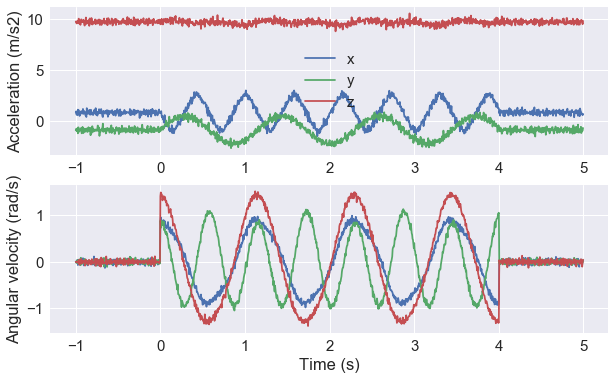

In [42]:
fig, ax = plt.subplots(2,1)
ax[0].plot(data.t, data.acc)
ax[0].set_ylabel('Acceleration (m/s2)')
ax[0].legend(['x','y','z'])
ax[1].plot(data.t, data.gyro)
ax[1].set_ylabel('Angular velocity (rad/s)')
ax[1].set_xlabel('Time (s)')

plt.show()

Process the data

In [43]:
acc = np.array(data.as_list_of_triples(0, 'accel'))
t = np.array(data.imu_data['timestamps'])/timescale
dt = np.mean(np.diff(t))

initial_gravity = np.mean(acc[t < 0.2, :], axis=0)

In [44]:
still_accel = np.array(data.as_list_of_triples(0, 'accel'))
still_accel = still_accel[t < 0, :]

still_gyro = np.array(data.as_list_of_triples(0, 'gyro'))
still_gyro = still_gyro[t < 0, :]

In [45]:
beta = np.sqrt(0.75) * np.max(2*np.std(still_gyro, axis=0))
print('beta = {:.3} rad/s = {:.3} deg/s'.format(beta, np.rad2deg(beta)))

beta = 0.0713 rad/s = 4.09 deg/s


In [48]:
process = Ic_process()


accdyn_dsf, orient_dsf, orient_dsf_rotm = process.get_orientation_dsf(0, initial_gravity, 
                                             np.array(basis_vector).T,
                                             still_accel, still_gyro, 
                                             data, 20)
accdyn_mad, orient_mad, orient_mad_rotm = process.get_orientation_madgwick(np.array(basis_vector).T,
                                                          data, 20,
                                                          beta=beta)

accdyn_dsf = np.array(accdyn_dsf)
orient_dsf = np.array(orient_dsf)
orient_dsf_rotm = np.array(orient_dsf_rotm)
accdyn_mad = np.array(accdyn_mad)
orient_mad = np.array(orient_mad)
orient_mad_rotm = np.array(orient_mad_rotm)

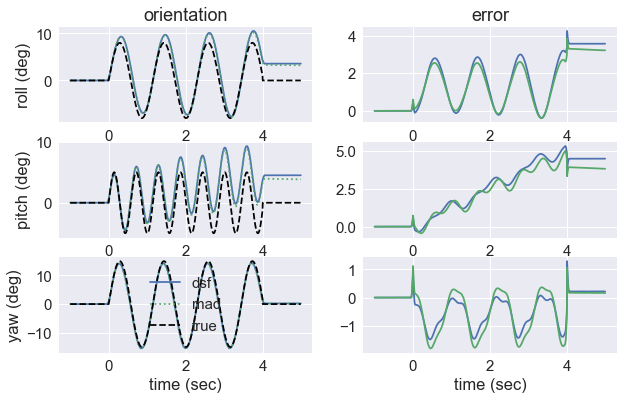

In [49]:
fig, ax = plt.subplots(3,2)

for odsf1, omad1, otrue1, ax1 in zip(np.rollaxis(orient_dsf, 1), np.rollaxis(orient_mad, 1), np.rollaxis(data.orient, 1), ax):
    ax1[0].plot(data.t, np.rad2deg(odsf1), label='dsf')
    ax1[0].plot(data.t, np.rad2deg(omad1), ':', label='mad')
    ax1[0].plot(data.t, np.rad2deg(otrue1), 'k--', label='true')

    ax1[1].plot(data.t, np.rad2deg(odsf1 - otrue1), label='dsf')
    ax1[1].plot(data.t, np.rad2deg(omad1 - otrue1), label='mad')
    
ax[0, 0].set_title('orientation')
ax[0, 0].set_ylabel('roll (deg)')
ax[1, 0].set_ylabel('pitch (deg)')
ax[2, 0].set_ylabel('yaw (deg)')
ax[2, 0].legend()
ax[2, 0].set_xlabel('time (sec)')

ax[0, 1].set_title('error')
ax[2, 1].set_xlabel('time (sec)')

plt.show()

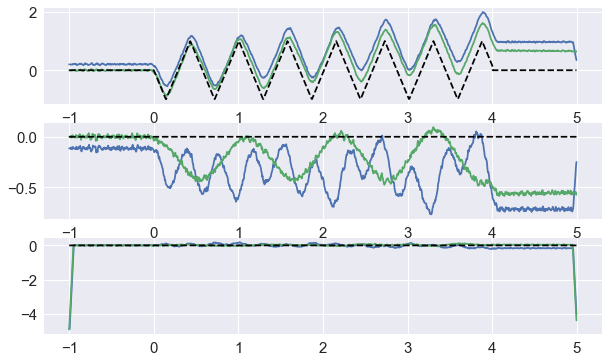

In [50]:
fig, ax = plt.subplots(3,1)

for adsf1, amad1, atrue1, ax in zip(np.rollaxis(accdyn_dsf, 1), np.rollaxis(accdyn_mad, 1), np.rollaxis(data.accdyn, 1), ax):
    ax.plot(data.t, adsf1, label='dsf')
    ax.plot(data.t, amad1, label='mad')
    ax.plot(data.t, atrue1, 'k--')